# Read The Data



In [1]:
import tensorflow as tf
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys

from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
# Run this code for the first time, to install the libraries and download wordnet
# %reset
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jasmine\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jasmine\AppData\Roaming\nltk_data...


True

In [2]:
data_vegan = 'data/vegan_recipes_final.csv'

data_vegan_df = pd.read_csv(data_vegan)

In [3]:
data_vegan_df.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,id
0,"['Halve the potatoes, unpeeled, and cut them i...",19.0,2004-08-20T04:00:00.000Z,"['Salad', 'Blender', 'Olive', 'Onion', 'Potato...",351.0,NaN,6.0,4.375,"Green Bean, Red Onion, and Roast Potato Salad ...","['3 pounds red boiling potatoes', '2/3 cup oli...",79.0,137739
1,['Cut off and discard 1 inch from stem ends of...,10.0,2004-08-20T04:00:00.000Z,"['Garlic', 'Side', 'Sauté', 'Vegetarian', 'Qui...",107.0,Active time: 25 min Start to finish: 30 min,4.0,4.375,Sauteed Broccoli Rabe,"['2 lb broccoli rabe', '3 large garlic cloves,...",329.0,31490
2,['Cut peel and white pith from grapefruits and...,1.0,2004-08-20T04:00:00.000Z,"['Salad', 'Breakfast', 'Brunch', 'No-Cook', 'Q...",191.0,NaN,3.0,4.375,Citrus Salad with Mint Sugar,"['2 white grapefruits', '2 pink grapefruits', ...",4.0,112140
3,['Preheat oven to 475°F. Pierce eggplants with...,7.0,2004-08-20T04:00:00.000Z,"['Condiment/Spread', 'Olive', 'Vegetable', 'Ro...",177.0,NaN,5.0,3.750,Roasted Eggplant and Olive Spread with Pita Br...,"['3 1-pound eggplants', '3 6- to 7-inch-diamet...",116.0,59389
4,"['Grind the parsley, sage, rosemary, and thyme...",12.0,2011-06-23T04:00:00.000Z,"['Microwave', 'Bake', 'Vegetarian', 'Wheat/Glu...",224.0,Wheat Free,21.0,3.125,Scarborough Fair Tofu Burger,"['1 tablespoon (2 g) dried parsley', '1 tables...",340.0,44061


In [4]:
num_rows = data_vegan_df.shape[0]
num_cols = data_vegan_df.shape[1]

print("number of rows:", num_rows)
print("number of columns:", num_cols)

number of rows: 1851
number of columns: 12


In [5]:
data_vegan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851 entries, 0 to 1850
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   directions   1851 non-null   object 
 1   fat          1455 non-null   float64
 2   date         1851 non-null   object 
 3   categories   1851 non-null   object 
 4   calories     1461 non-null   float64
 5   desc         1346 non-null   object 
 6   protein      1458 non-null   float64
 7   rating       1851 non-null   float64
 8   title        1851 non-null   object 
 9   ingredients  1851 non-null   object 
 10  sodium       1461 non-null   float64
 11  id           1851 non-null   int64  
dtypes: float64(5), int64(1), object(6)
memory usage: 173.7+ KB


# Data Pre-Process

Data processing steps:

* Check for missing values
* Convert all words into lowercase
* Check for imbalanced classes in dataset
* Removal of punctuation

In [6]:
# drop useless column 
cleaned_data_vegan = data_vegan_df.pop('date')
cleaned_data_vegan = data_vegan_df.pop('desc')

In [7]:
# drop NaN values in all rows
cleaned_data_vegan = data_vegan_df.dropna(axis=0)

In [8]:
# convert data into lowercase
cleaned_data_vegan = cleaned_data_vegan.apply(lambda x: x.astype(str).str.lower() if x.dtype == 'object' else x)

In [9]:
# removal of punctuation
def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    return text

cleaned_data_vegan = cleaned_data_vegan.applymap(remove_punctuation)


In [10]:
# Check for imbalanced classes in dataset
title_count = cleaned_data_vegan['title'].apply(lambda x: len(list(str(x).split())))
title_unique_word_count = cleaned_data_vegan['title'].apply(lambda x: len(set(str(x).split())))
title_digits = cleaned_data_vegan['title'].apply(lambda x: bool(re.search(r'\d', str(x))))

title_column_result = pd.concat([cleaned_data_vegan['title'], title_count, title_unique_word_count, title_digits], axis=1)
title_column_result.columns = ['Title', 'Title Count', 'Title Unique Word Count', 'Title Contains Digits']

In [11]:
title_column_result.head(5)

,Title,Title Count,Title Unique Word Count,Title Contains Digits
0,green bean red onion and roast potato salad wi...,11,11,False
1,sauteed broccoli rabe,3,3,False
2,citrus salad with mint sugar,5,5,False
3,roasted eggplant and olive spread with pita br...,9,9,False
4,scarborough fair tofu burger,4,4,False


In [12]:
title_column_result.tail(5)

,Title,Title Count,Title Unique Word Count,Title Contains Digits
1845,fresh tarragon oil,3,3,False
1846,wilted red cabbage and bell pepper slaw,7,7,False
1847,roasted and raw carrot salad with avocado and ...,11,10,False
1848,4321 spice rub,3,3,True
1850,blueberry compote,2,2,False


In [13]:
num_rows = cleaned_data_vegan.shape[0]
num_cols = cleaned_data_vegan.shape[1]

print("number of rows:", num_rows)
print("number of columns:", num_cols)

number of rows: 1455
number of columns: 10


In [14]:
cleaned_data_vegan.head()

,directions,fat,categories,calories,protein,rating,title,ingredients,sodium,id
0,halve the potatoes unpeeled and cut them into ...,19.0,salad blender olive onion potato side roast ve...,351.0,6.0,4.375,green bean red onion and roast potato salad wi...,3 pounds red boiling potatoes 23 cup olive oil...,79.0,137739
1,cut off and discard 1 inch from stem ends of b...,10.0,garlic side sauté vegetarian quick easy vegan...,107.0,4.0,4.375,sauteed broccoli rabe,2 lb broccoli rabe 3 large garlic cloves thinl...,329.0,31490
2,cut peel and white pith from grapefruits and o...,1.0,salad breakfast brunch nocook quick easy grap...,191.0,3.0,4.375,citrus salad with mint sugar,2 white grapefruits 2 pink grapefruits 6 large...,4.0,112140
3,preheat oven to 475°f pierce eggplants with fo...,7.0,condimentspread olive vegetable roast cocktail...,177.0,5.0,3.750,roasted eggplant and olive spread with pita br...,3 1pound eggplants 3 6 to 7inchdiameter pita b...,116.0,59389
4,grind the parsley sage rosemary and thyme into...,12.0,microwave bake vegetarian wheatglutenfree dinn...,224.0,21.0,3.125,scarborough fair tofu burger,1 tablespoon 2 g dried parsley 1 tablespoon 2 ...,340.0,44061


In [15]:
cleaned_data_vegan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1455 entries, 0 to 1850
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   directions   1455 non-null   object 
 1   fat          1455 non-null   float64
 2   categories   1455 non-null   object 
 3   calories     1455 non-null   float64
 4   protein      1455 non-null   float64
 5   rating       1455 non-null   float64
 6   title        1455 non-null   object 
 7   ingredients  1455 non-null   object 
 8   sodium       1455 non-null   float64
 9   id           1455 non-null   int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 125.0+ KB


# Data Exploration

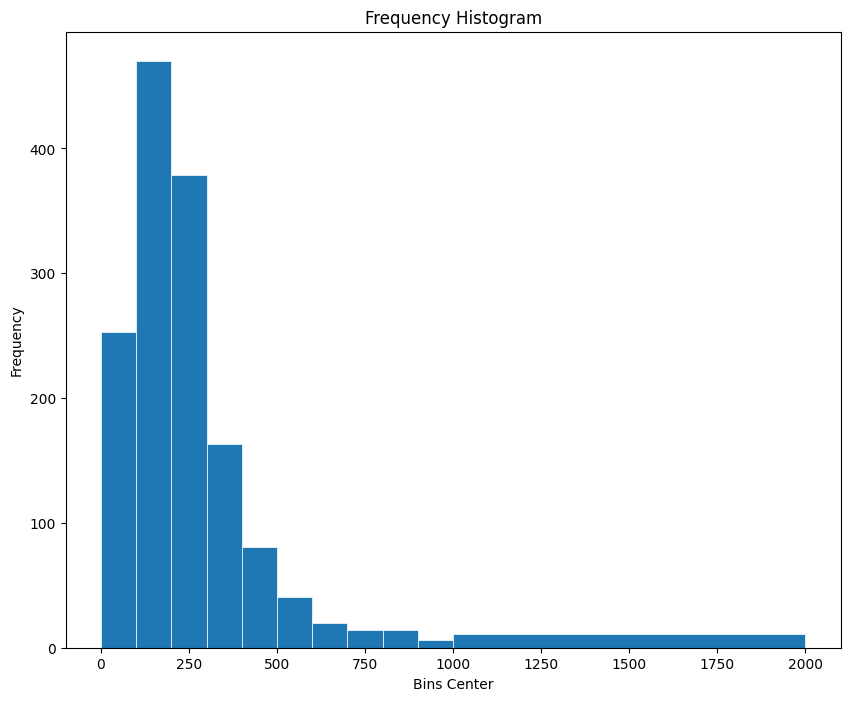

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Frequency Histogram')
plt.ylabel('Frequency')
plt.xlabel('Bins Center')

ax.hist(cleaned_data_vegan.calories.to_numpy(),bins=[0,100,200,300,400,500,600,700,800,900,1000,1000,2000],linewidth=0.5, edgecolor="white")
plt.show()

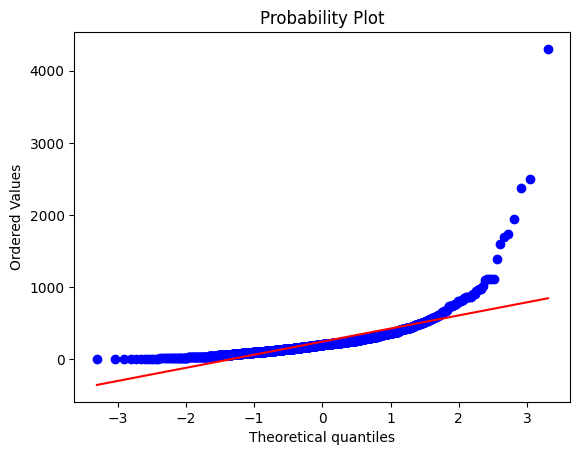

In [18]:
import pylab 
import scipy.stats as stats

stats.probplot(cleaned_data_vegan.calories.to_numpy(), dist="norm", plot=pylab)
pylab.show()

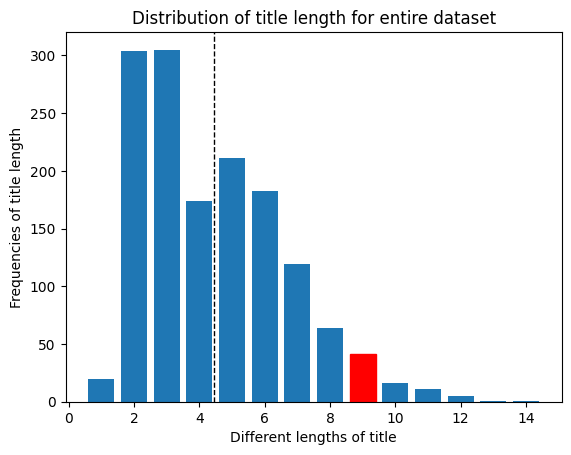

In [19]:
all_data = title_column_result.groupby('Title Count').count()

plt.xlabel('Different lengths of title')
plt.ylabel('Frequencies of title length')
plt.xticks(fontsize=10)
plt.title('Distribution of title length for entire dataset')
bar_graph = plt.bar(all_data.index, all_data['Title'])
bar_graph[8].set_color('r')

plt.axvline(title_column_result['Title Count'].mean(), color='k', linestyle='dashed', linewidth=1)

plt.show()

* difference in the length of recipe title is significant.
* median length of recipe title is around 9 words
* mean length of recipe title is around 4 words

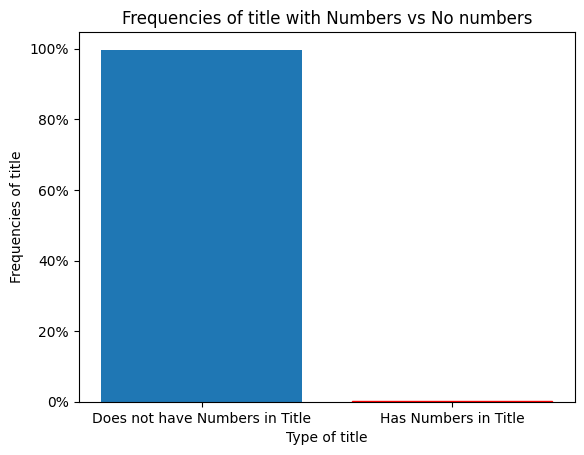

Does not have Numbers in Title    1.0
Has Numbers in Title              0.0
Name: Title, dtype: float64


In [20]:
data_digit = title_column_result.groupby('Title Contains Digits').count()
data_digit.index = ['Does not have Numbers in Title', 'Has Numbers in Title']

plt.xlabel('Type of title')
plt.ylabel('Frequencies of title')
plt.xticks(fontsize=10)
plt.title('Frequencies of title with Numbers vs No numbers')
bar_graph = plt.bar(data_digit.index, data_digit['Title'] / data_digit['Title Count'].sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

print(round(data_digit['Title'] / data_digit['Title Count'].sum(), 2))

* difference in the use of numbers/statistics in recipe title is significant.
* 100% recipe title uses text

# Identifying Topics in Dataset With LDA

Parameters:

* the number of topics
* the number of words per topic
* the number of topic per doc

### Pre-Process

* Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Removal of stop words.
* Removing Headlines that contains very few words. This helps to reduce the likelihood of headlines (that comprise of very but commonly-used words) matching together.
* Lemmatization: words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Stemming: words are reduced to their root form.

In [21]:
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    """this function is to tokenize the recipe title into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def get_lemma(word):
    """this function is to lemmatize the words in a recipe title into its root form"""
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def prepare_text_for_lda(text):
    """this function is to remove stopwords and lemmatize the words in a recipe title"""
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [22]:
# create a list of tokens for each recipe title
text_data = []
for title in cleaned_data_vegan['title']:
    tokens = prepare_text_for_lda(title)
    text_data.append(tokens)

In [23]:
# create a dictionary from the data
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

 Create a list of tokens for each recipe title

In [24]:
# create a list of tokens for each recipe title
import gensim

NUM_TOPICS = [3, 5, 10]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS[1], id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
topics

[(0, '0.041*"compote" + 0.035*"sorbet" + 0.031*"coconut" + 0.025*"pickle"'),
 (1, '0.047*"salsa" + 0.031*"tomato" + 0.029*"salad" + 0.026*"fresh"'),
 (2, '0.108*"salad" + 0.040*"green" + 0.036*"onion" + 0.027*"fennel"'),
 (3, '0.054*"salad" + 0.042*"garlic" + 0.039*"roast" + 0.022*"syrup"'),
 (4, '0.044*"sauce" + 0.040*"vegetable" + 0.037*"roast" + 0.025*"pepper"')]

In [25]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=4)
topics

[(0, '0.084*"salad" + 0.029*"potato" + 0.029*"green" + 0.019*"vinaigrette"'),
 (1, '0.037*"salsa" + 0.032*"roast" + 0.031*"vegetable" + 0.027*"carrot"'),
 (2, '0.039*"salad" + 0.030*"compote" + 0.021*"fruit" + 0.021*"pickle"')]

In [26]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
topics  

[(0, '0.064*"eggplant" + 0.049*"zucchini" + 0.046*"sesame" + 0.024*"pepper"'),
 (1, '0.072*"roast" + 0.054*"vegetable" + 0.048*"pepper" + 0.038*"salad"'),
 (2, '0.128*"salad" + 0.080*"green" + 0.066*"onion" + 0.042*"vinaigrette"'),
 (3, '0.103*"salsa" + 0.059*"compote" + 0.043*"spice" + 0.040*"fruit"'),
 (4, '0.058*"cranberry" + 0.043*"fresh" + 0.040*"syrup" + 0.038*"orange"'),
 (5, '0.044*"arugula" + 0.036*"tomato" + 0.033*"olive" + 0.030*"lemon"'),
 (6, '0.063*"ginger" + 0.035*"sugar" + 0.035*"garlic" + 0.030*"potato"'),
 (7, '0.131*"sauce" + 0.032*"apricot" + 0.031*"raspberry" + 0.024*"saute"'),
 (8, '0.093*"potato" + 0.071*"roast" + 0.045*"garlic" + 0.036*"sweet"'),
 (9, '0.194*"salad" + 0.036*"tomato" + 0.029*"cucumber" + 0.023*"cabbage"')]

In [27]:
# load the LDA model

lda5 = gensim.models.ldamodel.LdaModel.load('model5.gensim')
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')

 Print out the topics for each model

In [28]:
from numpy import mean

recipe_title = list(title_column_result['Title'] == 1)
tuple_list = []

for title in recipe_title:
    recipe_title_lda = lda5[corpus[title]]
    for tuple in recipe_title_lda:
        tuple_list.append(tuple)

print('For LDA model with 5 clusters:')
print('\nFor recipe title:')
print([(uk, mean([vv for kk, vv in tuple_list if kk == uk])) for uk in set([k for k, v in tuple_list])])

For LDA model with 5 clusters:

For recipe title:
[(0, 0.025002947), (1, 0.025160065), (2, 0.64694154), (3, 0.27745035), (4, 0.02544513)]


In [29]:
recipe_title = list(title_column_result['Title'] == 1)
tuple_list = []

for title in recipe_title:
    recipe_title_lda = lda3[corpus[title]]
    for tuple in recipe_title_lda:
        tuple_list.append(tuple)

print('For LDA model with 3 clusters:')
print('\nFor recipe title:')
print([(uk, mean([vv for kk, vv in tuple_list if kk == uk])) for uk in set([k for k, v in tuple_list])])

For LDA model with 3 clusters:

For recipe title:
[(0, 0.9131674), (1, 0.043943442), (2, 0.04288921)]


In [30]:
recipe_title = list(title_column_result['Title'] == 1)
tuple_list = []

for title in recipe_title:
    recipe_title_lda = lda10[corpus[title]]
    for tuple in recipe_title_lda:
        tuple_list.append(tuple)

print('For LDA model with 10 clusters:')
print('\nFor recipe title:')
print([(uk, mean([vv for kk, vv in tuple_list if kk == uk])) for uk in set([k for k, v in tuple_list])])

For LDA model with 10 clusters:

For recipe title:
[(0, 0.012500381), (1, 0.012502139), (2, 0.5045485), (3, 0.012500063), (4, 0.012500296), (5, 0.012500331), (6, 0.012500663), (7, 0.0125001455), (8, 0.39544532), (9, 0.0125021655)]


Summary
* LDA 5: represents a specific theme or style of salad 
* LDA 3: different styles or variations of salad recipes
* LDA 10: diverse range of recipe variations, each with its own unique combination of ingredients and flavors

# Build The models With Deep Learning

* RNN with Gated Recurrent Units (with Lasso Regularization, Dropout, Batch Normalization)
* RNN with Gated Recurrent Units (with Ridge Regularization, Dropout, Batch Normalization)
* RNN with Long Short Term Memory Units (with Lasso Regularization, Dropout, Batch Normalization)
* RNN with Long Short Term Memory Units (with Ridge Regularization, Dropout, Batch Normalization)
* CNN with Conv1D
* Combination of CNN-RNN (LSTM)

### RNN With GRU

In [16]:
train_data, test_data = train_test_split(cleaned_data_vegan['title'], test_size=0.2, random_state=42)

In [17]:
print("train set: ", len(train_data))
print("test set: ", len(test_data))

train set:  1164
test set:  291


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)
training_sequences = tokenizer.texts_to_sequences(train_data)
testing_sequences = tokenizer.texts_to_sequences(test_data)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(seq) for seq in training_sequences)

train_padded = pad_sequences(training_sequences, maxlen=max_length, padding='post')
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post')

embedding_dim = 100


In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from keras.optimizers import Adam


# Define the autoencoder model architecture
input_dim = max_length
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100


input_layer = Input(shape=(input_dim,))
# embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)
h_encoded = Dense(256, activation='relu')(input_layer)
h_encoded = Dense(128, activation='relu')(h_encoded)
h_encoded = Dense(64, activation='relu')(h_encoded)
h_encoded = Dense(32, activation='relu')(h_encoded)

encoded = Dense(16, activation='relu')(h_encoded)

h_decoded = Dense(32, activation='relu')(encoded)
h_decoded = Dense(64, activation='relu')(h_decoded)
h_decoded = Dense(128, activation='relu')(h_decoded)
h_decoded = Dense(256, activation='relu')(h_decoded)
output_layer = Dense(input_dim, activation='sigmoid')(h_decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=encoded)
adam = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_70 (Dense)            (None, 256)               3840      
                                                                 
 dense_71 (Dense)            (None, 128)               32896     
                                                                 
 dense_72 (Dense)            (None, 64)                8256      
                                                                 
 dense_73 (Dense)            (None, 32)                2080      
                                                                 
 dense_74 (Dense)            (None, 16)                528       
                                                                 
 dense_75 (Dense)            (None, 32)                544

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('recommender_system.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [45]:
num_epochs = 100
batch_size = 64

history = autoencoder.fit(
    train_padded,
    train_padded,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(testing_padded, testing_padded),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
15/19 [======================>.......] - ETA: 0s - loss: -5931.2856 - accuracy: 0.3354
Epoch 1: val_loss improved from inf to -60633.73047, saving model to recommender_system.h5
19/19 [==============================] - 2s 39ms/step - loss: -12141.5674 - accuracy: 0.3376 - val_loss: -60633.7305 - val_accuracy: 0.4261
Epoch 2/100
14/19 [=====================>........] - ETA: 0s - loss: -675096.4375 - accuracy: 0.3717
Epoch 2: val_loss improved from -60633.73047 to -5025944.00000, saving model to recommender_system.h5
19/19 [==============================] - 0s 16ms/step - loss: -1200372.8750 - accuracy: 0.3823 - val_loss: -5025944.0000 - val_accuracy: 0.4261
Epoch 3/100
16/19 [========================>.....] - ETA: 0s - loss: -53237944.0000 - accuracy: 0.3857
Epoch 3: val_loss improved from -5025944.00000 to -216604496.00000, saving model to recommender_system.h5
19/19 [==============================] - 0s 22ms/step - loss: -72743808.0000 - accuracy: 0.3823 - val_loss: -21660